# The Basics of Neural Network

In this review session, we will go through how to code a neural network by hand using `numpy`. The material used here is based on Andrew Ng's Deep Learning course on coursera. We will then apply off-the-shelf feedforward neural nets for different types of tasks. 

## Packages

First, let's run the cell below to import all the packages that you will need during this assignment. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score
%matplotlib inline

## Dataset

We will use the dataset from Angrist and Krueger (1991), and we will predict whether a person received more than 12 years of education (same exercise illustrated for binary logit).

In [2]:
# Loading the data (cat/non-cat)
df = pd.read_stata('../data/QOB7080_clean.dta')
YOB = ['YR2' + str(i) for i in range(9)]
# Controlling for race, marital status, standrad metropolitan statistical areas, and regions of residence
controls = ['RACE', 'MARRIED', 'SMSA',
            'NEWENG', 'MIDATL', 'ENOCENT',
            'WNOCENT', 'SOATL', 'ESOCENT',
            'WSOCENT', 'MT']
y = np.array(df['EDUC'] >= 12).T
X = np.array(df[['AGEQ', 'AGEQSQ'] + YOB + controls])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1680, stratify=y)


Many bugs in deep learning come from having incorrectly specified matrix/vector dimensions. It is always good to develop an understanding of what your dimensions are

In [3]:
m_train = X_train.shape[0]
m_test =  X_test.shape[0]
num_features = X_train.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Number of features for each observation = " + str(num_features))
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

Number of training examples: m_train = 197759
Number of testing examples: m_test = 49440
Number of features for each observation = 22
X_train shape: (197759, 22)
y_train shape: (197759,)
X_test shape: (49440, 22)
y_test shape: (49440,)


In [4]:
scaler = StandardScaler() #Control for scale of inputs
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train, y_train, X_test, y_test = X_train.T, y_train.T, X_test.T, y_test.T

## General Architecture of the learning algorithm


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## Building the parts of our algorithm

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters (usually zero)
3. Loop:
    - Calculate current loss (forward propagation): J
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### Helper functions

We want to first implement $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ to make predictions.

In [5]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1/(1 + np.exp(-z))    
    return s

### Initializing parameters

We will initialize w and bias to be zeros.

In [6]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

### Forward and Backward propagation

Now that our parameters are initialized, we can do the "forward" and "backward" propagation steps for learning the parameters.

Forward Propagation:
- We have X
- We compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- We calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas we will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [7]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)              # compute activation
    cost = np.sum((np.multiply((-np.log(A)), Y) + np.multiply((-np.log(1 - A)), (1 - Y))))/m  # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (np.dot(X,(A - Y).T))/m
    db = (np.sum(A - Y))/m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### Optimization
- We have initialized our parameters.
- We are also able to compute a cost function and its gradient.
- Now, we want to update the parameters using gradient descent.

The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [8]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    costs = []
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - (learning_rate*dw)
        b = b - (learning_rate*db)
        
        # Record the costs
        if i % 20 == 0:
            costs.append(cost)
        
        # Print the cost every 20 training iterations
        if print_cost and i % 20 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

The previous function will output the learned w and b. We now need to use w and b to predict the labels for a dataset X. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`.

In [9]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)           # Dimentions = (1, m)
    Y_prediction = (A >= 0.5)*1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction


Now, we've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## Merge all functions into a model ##

We will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

In [10]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    return d

Run the following cell to train your model.

In [11]:
d = model(X_train, y_train, X_test, y_test, num_iterations=500, learning_rate=0.1, print_cost=False)

train accuracy: 62.46795341804924 %
test accuracy: 62.44943365695793 %


Let's also plot the cost function and the gradients.

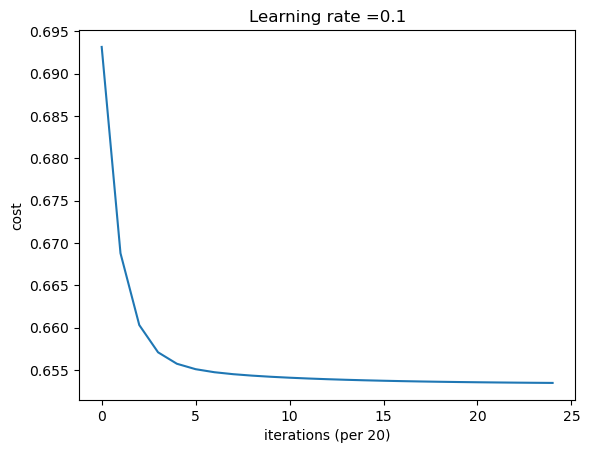

In [12]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per 20)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

## Comparison with Logistic Regression

The one-layer neural network is essentially identical to a logistic regression. We can see that only 1 percent of the prediction labels are different. This subtle difference can be attributed to our choice of learning rate, and the optimization method we pick to maximize our likelihood below. 

In [13]:
X_train_with_constant = sm.add_constant(X_train.T)
X_test_with_constant = sm.add_constant(X_test.T)

logit_res = sm.Logit(y_train.T, X_train_with_constant).fit(method='newton')
y_pred = (logit_res.predict(X_test_with_constant)>=0.5)*1.0
print(f'Testing accuracy is {100 - np.mean(np.abs(np.matrix(y_pred) - y_test))*100} %')
print(f'{np.mean(np.abs(np.matrix(y_pred) - d["Y_prediction_test"])) * 100} percent of the prediction results are different')

Optimization terminated successfully.
         Current function value: 0.653305
         Iterations 5
Testing accuracy is 62.57281553398058 %
1.1468446601941749 percent of the prediction results are different


## Neural Networks for Different Tasks

Now, I will demonstrate how to use neural network for two types of tasks: discrete prediction and continuous prediction. For classification tasks, we can use `MLPClassifier.`

0.6269449178039938
0.6287419093851133


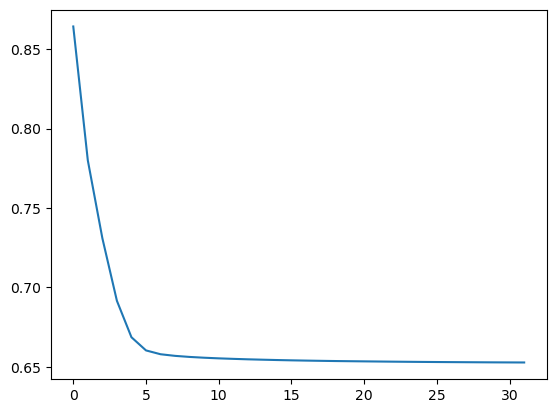

In [14]:
MLP_class = MLPClassifier(hidden_layer_sizes=(4, 2), random_state=1680,
                          max_iter=200, learning_rate_init=0.0001)
MLP_class.fit(X_train.T, np.ravel(y_train)) #estimate params
print(accuracy_score(y_train.T, MLP_class.predict(X_train.T))) # within sample accuracy
print(accuracy_score(y_test.T, MLP_class.predict(X_test.T))) # out of sample accuracy
plt.plot(MLP_class.loss_curve_)

For regressions, we can use `MLPRegressor`, which minimizes squared error. We can use it for the prediction of log weekly wage. We first load in our X and y. 

In [15]:
y = np.array(df['LWKLYWGE']).T
X = np.array(df[['EDUC', 'AGEQ', 'AGEQSQ'] + YOB + controls])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1680)
scaler = StandardScaler() #Control for scale of inputs
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

We then train the model. 

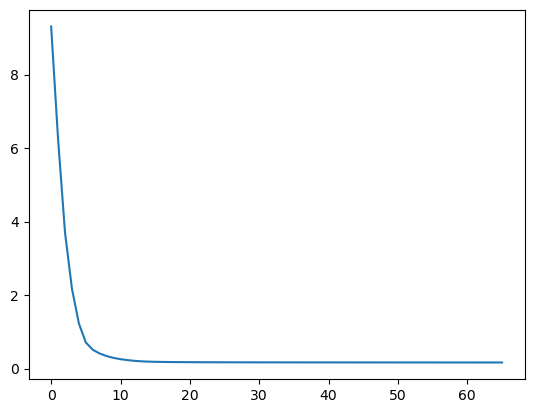

In [16]:
MLP_reg = MLPRegressor(hidden_layer_sizes=(4, 2), random_state=1680,
                       max_iter=200, learning_rate_init=0.0001)
MLP_reg.fit(X_train, np.ravel(y_train)) #estimate params
plt.plot(MLP_reg.loss_curve_)

For more customizability, check out tensorflow. To tune hyperparameters, we can set up grids of hyperparameters. Some of the things we usually tune for are learning rates, batch sizes, solver, and network sizes. 